# Meta Initialization For Image Segmentation Code

This kernel creates a meta neural network to provide starting weights and biases that will aid an agent in its training

In [1]:
# This version uses a model predicting in series of 100 trained with relu to create a head for a resnet18, optimial batch norm and activation functions are applied.

In [2]:
'''
Hypothesis:  a metanet can produce low enough losses when predicting weights that will fit a given error
that the initialization by this metanet would be extremely helpful, the challange in this kernel is to
find the exactly correct error for a 2 layer FC system with batch norm and activation functions to outperform 
other initialization methods.
'''

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import gc
from tqdm import tqdm
import os

cuda_is_available = True

bs = 1

import torchvision.models as models
resnet18 = models.googlenet(pretrained=True).eval()
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1])).cuda()


imsize = 1024
    
class Conv(nn.Module): # define Metanet working in series of 1
    def __init__(self):
        super(Conv, self).__init__()
        self.padding = 1
        self.norm = nn.ReLU()
        
        self.W1 = nn.Conv2d(bs*20, bs*10, 7, 1, 3, bias=False)
        self.W2 = nn.Conv2d(bs*10, bs*10, 3, 1, self.padding, bias=False)
        self.W6 = nn.Conv2d(bs*10, 10, 3, 1, self.padding, bias=False)
        
    def forward(self, x):
        x1 = self.norm(self.W1(x))
        x = self.norm(self.W2(x1))
        x = self.W6(x)
       
        return x

updaterw = Conv()
if cuda_is_available:
    updaterw = updaterw.cuda()

def forward_backward(x, y): # run Metanet on one sample and generate its loss
    x = f(x).float()

    yee = torch.tensor([])
    if cuda_is_available:
        yee = torch.tensor([]).cuda()
        x = x.cuda()
        y = y.cuda()
    for b in range(bs):
        if cuda_is_available:
            ye = torch.zeros([10]).cuda()
        else:
            ye = torch.zeros([10])
        ye[y] = 10
        yee = torch.cat([yee, ye])

    secondary = yee.reshape([bs, 10]).repeat(imsize, 1).reshape([bs*imsize, 10])
    
    x = (nn.ReLU()(x).reshape([1, 1, 1024])).reshape(1, 1024) # nn.InstanceNorm1d(1024)

    win = torch.cat([secondary, x.reshape([bs*imsize,1]).repeat(1, 10).reshape([bs*imsize, 10])]).reshape([1, bs*20, 32, 32])
    w1 = updaterw(win) #794

    pred = (torch.mm(x, w1.reshape([imsize, 10])))
    
    loss = nn.CrossEntropyLoss()(pred.reshape([bs, 10]), y) #nn.Softmax() 

    optimizerw.zero_grad()
    loss.backward(retain_graph=True)
    optimizerw.step()

    return loss
    

# get dataset    

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.CIFAR10(root='./MNIST', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./MNIST', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=0)


del trainset, testset

gc.collect()
torch.cuda.empty_cache()


updaterw = Conv()
if cuda_is_available:
    updaterw = updaterw.cuda()

optimizerw = torch.optim.Adam(updaterw.parameters(), lr=0.0001)
    

#updaterw.load_state_dict(torch.load('../input/bupdaterw/updaterw_CFIARb', map_location=torch.device('cuda')))
#updaterw.eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


Extracting ./MNIST/cifar-10-python.tar.gz to ./MNIST
Files already downloaded and verified



In [3]:
# train m1

for lolo in range(1): # 4-6
    b = 0
    t = tqdm(trainloader)
    losso = 0
    f = nn.Flatten()
    inc = 0
    for (x, y) in t:
        
        if cuda_is_available:
            x = x.cuda()
        
        loss = forward_backward(resnet18(x).reshape([bs, 1, 32, 32]), y)
        
        losso += loss
        inc += 1
        t.set_description(str(losso/inc))
        del loss
        
        if inc % 50 == 0:
            b += 1
            del losso
            losso = 0
            inc = 0
            gc.collect()
            torch.cuda.empty_cache()
            if b == 5: # dont need all epochs, learns pretty quick
                break

tensor(0., device='cuda:0', grad_fn=<DivBackward0>):   0%|          | 249/50000 [00:07<25:40, 32.29it/s]


In [4]:
torch.save(updaterw.state_dict(), 'updaterw_CFIAR')

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
mbs = 100

gc.collect()
torch.cuda.empty_cache()

# define Metanet working in series of 100
class ConvM2(nn.Module):
    def __init__(self):
        super(ConvM2, self).__init__()
        self.padding = 1
        
        self.norm = nn.ReLU()
        
        self.W1 = nn.Conv2d(mbs*2*10, mbs*2*10, 3, 1, self.padding, bias=False)
        self.W2 = nn.Conv2d(mbs*2*10, mbs*16, 3, 1, self.padding, bias=False)
        self.W3 = nn.Conv2d(mbs*16, mbs*16, 3, 1, self.padding, bias=False)
        self.W4 = nn.Conv2d(mbs*16, mbs*16, 3, 1, self.padding, bias=False)
        self.W5 = nn.Conv2d(mbs*16, imsize, 3, 1, self.padding, bias=False)
        
        self.W6 = nn.Conv2d(mbs*16, mbs*16, 3, 1, self.padding, bias=False)
        self.W7 = nn.Conv2d(mbs*16, mbs*2, 3, 1, self.padding, bias=False)
        self.W8 = nn.Conv2d(mbs*2, mbs, 3, 1, self.padding, bias=False)
        self.W9 = nn.Conv2d(mbs, 10, 3, 1, self.padding, bias=False)
        
    def forward(self, x):
        
        x1 = self.norm(self.W1(x))
        x = self.norm(self.W2(x1))
        x = self.norm(self.W3(x))
        x2 = self.norm(self.W4(x))
        r1 = self.W5(x2)
        
        x = self.norm(self.W6(x2))
        x = self.norm(self.W7(x))
        x = self.norm(self.W8(x))
        r2 = self.W9(x)
        
        return r1, r2
    
m2 = ConvM2()
if cuda_is_available:
    m2 = m2.cuda()
    
# get dataset
    
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.CIFAR10(root='./MNIST', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=mbs,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./MNIST', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=mbs,
                                         shuffle=False, num_workers=0)


del trainset
del testset

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# one forward and backward of 100 series model

def forward_backwardM2(x, y, optimizer):
    
    x = f(x).float()

    yee = torch.tensor([])
    if cuda_is_available:
        yee = torch.tensor([]).cuda()
        x = x.cuda()
        y = y.cuda()
    for b in range(mbs):
        if cuda_is_available:
            ye = torch.zeros([10]).cuda()
        else:
            ye = torch.zeros([10])
        ye[y] = 10
        yee = torch.cat([yee, ye])
    x =  nn.BatchNorm1d(1024).cuda()(nn.ReLU()(x)) #
        
    secondary = yee.reshape([mbs, 10]).repeat(imsize, 1).reshape([mbs*imsize, 10])
    win = torch.cat([secondary, x.reshape([mbs*imsize,1]).repeat(1, 10).reshape([mbs*imsize, 10])]).reshape([mbs, 20, 32, 32])
    w1 = torch.cat([updaterw(win).detach().reshape([mbs, 10, imsize]), x.reshape([mbs, 1, imsize]).repeat(1, 10, 1)]).reshape([1, mbs*2*10, 1, imsize]) #794

    weights = m2(w1)
    

    pred = (torch.mm((nn.ReLU()(torch.mm(x, weights[0].reshape([imsize, imsize])))), weights[1].reshape([imsize, 10]))) #nn.Softmax()  nn.ReLU() nn.ReLU() nn.BatchNorm1d(1024).cuda()

    loss = nn.CrossEntropyLoss()(pred.reshape([mbs, 10]), y) #nn.Softmax() 

    return loss

In [8]:
gc.collect()
torch.cuda.empty_cache()

optim2 = torch.optim.Adam(m2.parameters(), lr=0.00005)

# test accuracy of initialization weights produced
def testinv():
    t = enumerate(testloader)
    losso = 0
    f = nn.Flatten()
    for i, (x, y) in t:
        
        x = f(resnet18(x.cuda())).float()
        yee = torch.tensor([])
        if cuda_is_available:
            yee = torch.tensor([]).cuda()
            x = x.cuda()
            y = y.cuda()
        for b in range(mbs):
            if cuda_is_available:
                ye = torch.zeros([10]).cuda()
            else:
                ye = torch.zeros([10])
            ye[y] = 10
            yee = torch.cat([yee, ye])
            
        x = nn.BatchNorm1d(1024).cuda()(nn.ReLU()(x)) #
        secondary = yee.reshape([mbs, 10]).repeat(imsize, 1).reshape([mbs*imsize, 10])
        win = torch.cat([secondary, x.reshape([mbs*imsize,1]).repeat(1, 10).reshape([mbs*imsize, 10])]).reshape([mbs, 20, 32, 32])

        w1 = torch.cat([updaterw(win).detach().reshape([mbs, 10, imsize]), x.reshape([mbs, 1, imsize]).repeat(1, 10, 1)]).reshape([1, mbs*2*10, 1, imsize]) #794

        weights = m2(w1)
    

        pred = torch.argmax((torch.mm((nn.ReLU()(torch.mm(x, weights[0].reshape([imsize, imsize])))), weights[1].reshape([imsize, 10]))),axis=1) #nn.ReLU() nn.BatchNorm1d(1024).cuda()
        
        if mbs != 1:
            for ll in range(mbs):
                if pred.reshape([mbs])[ll] == y[ll]: #nn.Softmax()
                    losso += 1
        else:
            if pred == y:
                losso += 1

        if i == 10:
             return weights,losso/(11*mbs)

In [9]:
#m2.load_state_dict(torch.load('../input/bs50-model-save-epoch-15/bs50_model_save_epoch_15.pth', map_location=torch.device('cuda'))) #m2.load_state_dict(torch.load('../input/bs50-model-save-epoch-15/bs50_model_save_epoch_15.pth', map_location=torch.device('cuda'))) # #

In [10]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

def update(loss, optim):
    optim.zero_grad()
    loss.backward(retain_graph=True)
    optim.step()

# train bs100 model
for lolo in range(50): # 4-6
    f = nn.Flatten()
    t = tqdm(trainloader)
    losso = 0
    passed = 0
    inc = 0
    for (x, y) in t:
        
        inc += 1
        
        #if inc < 388 and passed == 0:
        #    continue
            
        #if inc == 388:
        #    inc = 0
        #    passed = 1
        
        if x.shape[0] != mbs:
            break
        
        if cuda_is_available:
            x = x.cuda()
        
        loss = forward_backwardM2(resnet18(x), y, optim2) # compute error, updates, apply
        
        update(loss, optim2)
        
        losso += loss

        
        t.set_description(str(losso/inc))
        del loss
        
        
        
        if inc % 10 == 0: # make sure curren  t error estimate is not clogged by past, also helps with memory
            del losso
            losso = 0
            inc = 0
            gc.collect()
            torch.cuda.empty_cache()
        
    _, acc = testinv() # weight for individual 250 batch
    print(acc)
    del _
            
        
# find best parameter notes
# 1200 --> 1.5644 STD: .02


# 213: 2.3026 relu-softmax
# 120 1.94 non
# 120: 2.229 softmax-only
# 120: 1.72 relu only - the best one!!!

# 1.8552

# no bias, 100, no instance, batch norm and relu - .509090909090909
# no bias, 100, instance, batch norm and relu - 0.4509090909090909

# no bias, 100, no instance, batch norm and relu - .509090909090909
# no bias, 100, no instance, relu - 0.5336363636363637

# no bias, 100, relu - 0.5336363636363637
# one bias, 100, relu - 0.46

# 100, relu 25e - 
# 50, relu 25e - 

tensor(1.8888, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.32545454545454544


tensor(1.4331, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5163636363636364


tensor(1.3480, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5581818181818182


tensor(1.2808, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5727272727272728


tensor(1.2761, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5772727272727273


tensor(1.0366, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5845454545454546


tensor(1.1699, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.58


tensor(1.2428, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5854545454545454


tensor(1.1339, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:02<00:00,  2.06it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5818181818181818


tensor(1.0261, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:02<00:00,  2.06it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5772727272727273


tensor(1.1374, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5736363636363636


tensor(1.0780, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5763636363636364


tensor(1.0338, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5809090909090909


tensor(1.0866, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5881818181818181


tensor(1.0072, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5763636363636364


tensor(1.1371, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5690909090909091


tensor(1.1285, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5827272727272728


tensor(0.9975, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5727272727272728


tensor(0.9766, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5718181818181818


tensor(1.0250, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5736363636363636


tensor(0.9965, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5745454545454546


tensor(0.9889, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5736363636363636


tensor(1.0739, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5772727272727273


tensor(0.9830, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5781818181818181


tensor(1.0745, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5663636363636364


tensor(1.0432, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5690909090909091


tensor(0.9551, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5772727272727273


tensor(0.9700, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5636363636363636


tensor(0.9800, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5681818181818182


tensor(1.0266, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5663636363636364


tensor(0.9528, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5763636363636364


tensor(0.9695, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5581818181818182


tensor(0.9626, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5636363636363636


tensor(0.9709, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5627272727272727


tensor(0.9541, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5672727272727273


tensor(0.8669, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5581818181818182


tensor(0.9746, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5554545454545454


tensor(0.9523, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5618181818181818


tensor(0.9470, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5636363636363636


tensor(0.9238, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5690909090909091


tensor(0.8887, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5590909090909091


tensor(0.8347, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5618181818181818


tensor(0.8863, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5536363636363636


tensor(0.8818, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5445454545454546


tensor(0.9436, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5572727272727273


tensor(0.8486, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5663636363636364


tensor(0.7794, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5654545454545454


tensor(0.8530, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5772727272727273


tensor(0.8614, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]
  0%|          | 0/500 [00:00<?, ?it/s]

0.5672727272727273


tensor(0.7594, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


0.5618181818181818


In [11]:
torch.save(m2.state_dict(), 'bs100_model_save_epoch_40.pth')

In [12]:
#m2.eval()
_, acc = testinv() # weight for individual 100 batch
print(acc)

0.5618181818181818


# Training off of initailization
## Results
The metainitialized method does well right off the bat but soon dips in comparison to the model initialized off of truncated normals.

In [13]:

# tests weights that we will use for further training
def test():
    t = enumerate(testloader)
    losso = 0
    f = nn.Flatten()
    for i, (x, y) in t:
        
        x = f(resnet18(x.cuda())).float()
        yee = torch.tensor([])
        if cuda_is_available:
            yee = torch.tensor([]).cuda()
            x = x.cuda()
            y = y.cuda()
        for b in range(mbs):
            if cuda_is_available:
                ye = torch.zeros([10]).cuda()
            else:
                ye = torch.zeros([10])
            ye[y] = 10
            yee = torch.cat([yee, ye])
            
        #if i == 0:
        
        x = nn.BatchNorm1d(1024).cuda()(nn.ReLU()(x))
        secondary = yee.reshape([mbs, 10]).repeat(imsize, 1).reshape([mbs*imsize, 10])
        win = torch.cat([secondary, x.reshape([mbs*imsize,1]).repeat(1, 10).reshape([mbs*imsize, 10])]).reshape([mbs, 20, 32, 32])

        w1 = torch.cat([updaterw(win).detach().reshape([mbs, 10, imsize]), x.reshape([mbs, 1, imsize]).repeat(1, 10, 1)]).reshape([1, mbs*2*10, 1, imsize]) #794

        weights = m2(w1)

        pred = torch.argmax(torch.mm((nn.ReLU()(torch.mm(x, weights[0].reshape([imsize, imsize])))), weights[1].reshape([imsize, 10])),axis=1)
        
        if mbs != 1:
            for ll in range(mbs):
                if pred.reshape([mbs])[ll] == y[ll]: #nn.Softmax()
                    losso += 1
        else:
            if pred == y:
                losso += 1

        if i == 10:
             return weights,losso/(11*mbs)
    return weights, losso/(2*mbs)

weight, acc = test() # weight for one batch used for all
print(acc)

# model using initialization weights
class using_wpred(nn.Module):
    def __init__(self):
        super(using_wpred, self).__init__()
        
        self.b = nn.BatchNorm1d(1024)
        self.W3 = nn.Linear(1024, 1024)
        self.r = nn.ReLU()
        
    def forward(self, x):
        
        x = self.r(self.b(x))
        x = self.W3(x)
        
        return x

    
print('-------------------- predicted -----------------')
# predicted
model = using_wpred().cuda()
optimizerl = torch.optim.SGD(model.parameters(), lr=0.001)
w1 = nn.Parameter(weight[0].reshape([1024, 1024]), requires_grad=True) # using predicted
w2 = nn.Parameter(weight[1].reshape([1024, 10]), requires_grad=False) # using predicted
losso = 0
total = 0
f = nn.Flatten()
losslist1 = []

iterator = tqdm(range(100))
for lli in iterator:
    t = testloader
    for i, (x, y) in enumerate(t):
        x = f(resnet18(x.cuda())).float()
        y = y.cuda()
        pred = nn.BatchNorm1d(1024).cuda()(nn.ReLU()(model(x))) #  
        pred = ((torch.mm(pred, w1))) #nn.BatchNorm1d(1024).cuda() nn.ReLU()
        pred = (torch.mm(pred,w2))
        loss = nn.CrossEntropyLoss()(pred, y)
        optimizerl.zero_grad()
        loss.backward()
        optimizerl.step()
        pred = torch.argmax(pred, axis=1)
        for ll in range(bs):
            if pred.reshape([mbs])[ll] == y[ll]:
                losso += 1
            total += 1
        iterator.set_description(str(losso/total))
    losslist1.append(losso/total)
        
del model


print('-------------------- baseline -----------------')
# baseline
modelo = using_wpred().cuda()
optimizerl = torch.optim.SGD(modelo.parameters(), lr=0.001)
w1 = nn.Parameter(torch.randn(1024, 1024), requires_grad=True).cuda() # baseline
w2 = nn.Parameter(torch.randn(1024, 10), requires_grad=True).cuda() # baseline
losso = 0
total = 0
losslist2 = []


f = nn.Flatten()
iterator = tqdm(range(100))
for lli in iterator:
    t = testloader
    for i, (x, y) in enumerate(t):
        x = f(resnet18(x.cuda())).float()
        y = y.cuda()
        pred = nn.BatchNorm1d(1024).cuda()(nn.ReLU()(modelo(x)))
        pred = nn.BatchNorm1d(1024).cuda()(nn.ReLU()(torch.mm(pred, w1)))
        pred = torch.mm(pred,w2)
        loss = nn.CrossEntropyLoss()(pred, y)
        optimizerl.zero_grad()
        loss.backward(retain_graph=True)
        optimizerl.step()
        pred = torch.argmax(pred, axis=1)
        for ll in range(bs):
            if pred.reshape([mbs])[ll] == y[ll]:
                losso += 1
            total += 1
        iterator.set_description(str(losso/total)) 
    losslist2.append(losso/total)

    


0.0:   0%|          | 0/100 [00:00<?, ?it/s]

0.5618181818181818
-------------------- predicted -----------------


0.3333333333333333:   0%|          | 0/100 [00:00<?, ?it/s]

-------------------- baseline -----------------


0.9884: 100%|██████████| 100/100 [09:02<00:00,  5.43s/it]


baseline: [0.31, 0.495, 0.6233333333333333, 0.71, 0.768, 0.8066666666666666, 0.8342857142857143, 0.855, 0.8711111111111111, 0.884, 0.8945454545454545, 0.9033333333333333, 0.9107692307692308, 0.9171428571428571, 0.9226666666666666, 0.9275, 0.9317647058823529, 0.9355555555555556, 0.9389473684210526, 0.942, 0.9447619047619048, 0.9472727272727273, 0.9495652173913044, 0.9516666666666667, 0.9536, 0.9553846153846154, 0.957037037037037, 0.9585714285714285, 0.96, 0.9613333333333334, 0.9625806451612903, 0.96375, 0.9648484848484848, 0.9658823529411765, 0.9668571428571429, 0.9677777777777777, 0.9686486486486486, 0.9694736842105263, 0.9702564102564103, 0.971, 0.9717073170731707, 0.9723809523809523, 0.9730232558139534, 0.9736363636363636, 0.9742222222222222, 0.9747826086956521, 0.9753191489361702, 0.9758333333333333, 0.976326530612245, 0.9768, 0.9772549019607844, 0.9776923076923076, 0.9781132075471698, 0.9785185185185186, 0.978909090909091, 0.9792857142857143, 0.9796491228070175, 0.98, 0.98033898305

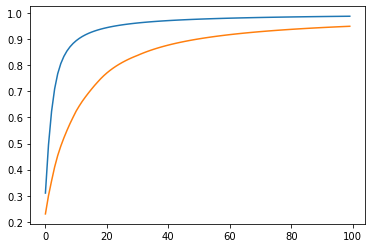

In [14]:
# results
print('baseline:', losslist2)
print('predicted:', losslist1)

import matplotlib.pyplot as plt

plt.plot(range(len(losslist2)), losslist2, label='baseline')
plt.plot(range(len(losslist1)), losslist1, label='predicted')
plt.show()

## Conclusions
In order to find a better method of initialization we must find a way that will have a similar randomness and proclivity to do well after the initialization proccess. In the current moment I do not wish to pursue this project any longer becuase it seems to not be producing results.